In [1]:
!pip install transformers datasets scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 517.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
 

In [2]:
import pandas as pd
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset


In [3]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET


In [4]:
def extract_data(files):

    result = []

    for path in files:
        # Abre y parsea el archivo XML
        tree = ET.parse(path)
        # Obtiene el elemento raíz del archivo XML
        root = tree.getroot()
        # Extrae la información que necesitas
        for nlm_question in root.findall(".//NLM-QUESTION"):

            message = nlm_question.find(".//MESSAGE").text
            focus = nlm_question.find(".//FOCUS").text
            category = nlm_question.find(".//TYPE").text
            answers = [answer.text for answer in nlm_question.findall(".//ANSWER")]
            result.append({"message": message, "focus": focus, "category": category,"answers": answers})

    df = pd.DataFrame(result)
    df = df.explode('answers')

    return df

extract_data(["/content/TREC-2017-LiveQA-Medical-Train-1.xml", "/content/TREC-2017-LiveQA-Medical-Train-2.xml"]).head(10)

,message,focus,category,answers
0,Literature on Cardiac amyloidosis. Please let...,cardiac amyloidosis,information,Cardiac amyloidosis is a disorder caused by de...
0,Literature on Cardiac amyloidosis. Please let...,cardiac amyloidosis,information,"The term ""amyloidosis"" refers not to a single ..."
1,Migraine seems to be a spectrum of conditions ...,migraine,treatment,There is no specific cure for migraine headach...
1,Migraine seems to be a spectrum of conditions ...,migraine,treatment,There is no absolute cure for migraine since i...
2,DO I USE PYRIDOXINE TABLETS EVEN IF IM PREGNANT?,pyridoxine,contraindication,"Before taking pyridoxine, tell your doc..."
3,i have lymphoma what causes cramp after chemo ...,cramp,cause,Muscle cramps are common and often occur when ...
4,I wonder of new research and testing on macula...,macular degeneration,treatment,These resources address the diagnosis or manag...
5,Can you please send me as much information as ...,hypothyroidism,information,Hypothyroidism is a condition in which the thy...
5,Can you please send me as much information as ...,hypothyroidism,information,Summary Your thyroid is a butterfly-shap...
5,Can you please send me as much information as ...,hypothyroidism,information,Hypothyroidism is a disorder that occurs when ...


In [5]:
df_raw = extract_data(["/content/TREC-2017-LiveQA-Medical-Train-1.xml", "/content/TREC-2017-LiveQA-Medical-Train-2.xml"])

In [6]:
import re

def clean_text(text):

    contractions = [
    r"won\'t", r"I\'m", r"can\'t", r"don\'t", r"doesn\'t", r"shouldn\'t", r"needn\'t", r"hasn\'t", r"haven\'t",
    r"weren\'t", r"mightn\'t", r"didn\'t", r"aren\'t", r"isn\'t", r"wouldn\'t", r"couldn\'t",
    r"wasn\'t", r"it\'s", r"you\'re", r"he\'s", r"she\'s", r"we\'re", r"they\'re", r"I\'d",
    r"you\'d", r"he\'d", r"she\'d", r"we\'d", r"they\'d", r"I\'ll", r"you\'ll", r"he\'ll",
    r"she\'ll", r"we\'ll", r"they\'ll", r"I\'ve", r"you\'ve", r"we\'ve", r"they\'ve", r"\'m"]

    full_words = [
    " will not"," I am", " cannot", " do not", " does not", " should not", " need not", " has not",
    " have not", " were not", " might not", " did not", " are not", " is not",
    " would not", " could not", " was not", " it is", " you are", " he is", " she is",
    " we are", " they are", " I would", " you would", " he would", " she would",
    " we would", " they would", " I will", " you will", " he will", " she will",
    " we will", " they will", " I have", " you have", " we have", " they have", " am"]

    for contraction, full_word in zip(contractions, full_words): #Change contractions with full words
        text = re.sub(contraction, full_word, text)

    text = re.sub(r"\'s","", text) #Delete apostrophes
    text = re.sub(r"\r\n"," ", text)

    text = re.sub(r"[^A-Za-z\s]", "", text) #Delete special characters

    text = text.lower() #change to lowercase letters
    text = re.sub(r"[ ]+" , " " , text)

    return text

def clean_df(df):

    for col in df.columns:
        df[col] = df[col].apply(clean_text)

    return df

In [7]:
df_raw.dropna(inplace=True)

In [8]:
df_clean = clean_df(df_raw)

df_clean.head()

,message,focus,category,answers
0,literature on cardiac amyloidosis please let m...,cardiac amyloidosis,information,cardiac amyloidosis is a disorder caused by de...
0,literature on cardiac amyloidosis please let m...,cardiac amyloidosis,information,the term amyloidosis refers not to a single di...
1,migraine seems to be a spectrum of conditions ...,migraine,treatment,there is no specific cure for migraine headach...
1,migraine seems to be a spectrum of conditions ...,migraine,treatment,there is no absolute cure for migraine since i...
2,do i use pyridoxine tablets even if im pregnant,pyridoxine,contraindication,before taking pyridoxine tell your doctor and ...


In [21]:
## Sustituimos algunas etiquetas
cat_to_map = {'association': 'association',
 'cause': 'cause',
 'complication': 'other',
 'contraindication': 'information',
 'diagnoseme': 'diagnosis',
 'diagnosis': 'diagnosis',
 'dosage': 'usage',
 'genetic changes': 'other',
 'indication': 'indication',
 'information': 'information',
 'ingredient': 'other',
 'inheritance': 'other',
 'interaction': 'indication',
 'organization': 'organization',
 'prevention': 'other',
 'prognosis': 'prognosis',
 'side effects': 'other',
 'storage and disposal': 'indication',
 'susceptibility': 'susceptibility',
 'symptom': 'symptom',
 'tapering': 'other',
 'treatment': 'treatment',
 'usage': 'indication'}

cat_to_map_2 = {'association': 'other',
 'cause': 'other',
 'complication': 'other',
 'contraindication': 'other',
 'diagnoseme': 'other',
 'diagnosis': 'other',
 'dosage': 'other',
 'genetic changes': 'other',
 'indication': 'other',
 'information': 'information',
 'ingredient': 'other',
 'inheritance': 'other',
 'interaction': 'other',
 'organization': 'other',
 'prevention': 'other',
 'prognosis': 'other',
 'side effects': 'other',
 'storage and disposal': 'other',
 'susceptibility': 'other',
 'symptom': 'other',
 'tapering': 'other',
 'treatment': 'treatment',
 'usage': 'other',
 'association': 'other'}

df_clean["category_other"] = df_clean['category'].map(cat_to_map)
df_clean["category_general"] = df_clean['category'].map(cat_to_map_2)

In [22]:
df_clean

,message,focus,category,answers,category_other,category_general,category_general_coded
0,literature on cardiac amyloidosis please let m...,cardiac amyloidosis,information,cardiac amyloidosis is a disorder caused by de...,information,information,0
0,literature on cardiac amyloidosis please let m...,cardiac amyloidosis,information,the term amyloidosis refers not to a single di...,information,information,0
1,migraine seems to be a spectrum of conditions ...,migraine,treatment,there is no specific cure for migraine headach...,treatment,treatment,1
1,migraine seems to be a spectrum of conditions ...,migraine,treatment,there is no absolute cure for migraine since i...,treatment,treatment,1
2,do i use pyridoxine tablets even if im pregnant,pyridoxine,contraindication,before taking pyridoxine tell your doctor and ...,information,other,0
...,...,...,...,...,...,...,...
441,if you should contact mrsa and take antibiotic...,mrsa,diagnosis,occasionally a person who has been treated for...,diagnosis,other,0
442,what if you do not have surgery to remove a pa...,intraductal papilloma,prognosis,your specialist will be able to advise you of ...,prognosis,other,0
443,thank for your information on my earlier quest...,excessive tears,treatment,your doctor may order tests to help determine ...,treatment,treatment,1
444,i have numbnesstingling in my lower right arm ...,numbnesstingling,treatment,home care your doctor should find and treat th...,treatment,treatment,1


In [14]:
!pip install accelerate -U

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [23]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support  # Importar las métricas necesarias

#Codificar etiquetas

label_encoder = LabelEncoder()
df_clean['category_general_coded'] = label_encoder.fit_transform(df_clean['category_general'])

# Dividir el DataFrame en conjuntos de entrenamiento y prueba
train_df, test_df = train_test_split(df_clean, test_size=0.2, stratify=df_clean['category_general'])

# Convertir los DataFrames a datasets de Hugging Face
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenizar el dataset
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
def tokenize_function(examples):
    return tokenizer(examples['message'], padding='max_length', truncation=True)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Asegurarse de que las etiquetas sean enteros
def encode_labels(dataset):
    dataset = dataset.map(lambda examples: {'labels': int(examples['category_general_coded'])})
    return dataset

tokenized_train_dataset = encode_labels(tokenized_train_dataset)
tokenized_test_dataset = encode_labels(tokenized_test_dataset)

# Cargar el modelo preentrenado
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(df_clean['category_general'].unique()))

# Configurar los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
)

# Definir una función para calcular las métricas:

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Definir el entrenador
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics

)

# Entrenar el modelo
trainer.train()

Map:   0%|          | 0/505 [00:00<?, ? examples/s]

Map:   0%|          | 0/127 [00:00<?, ? examples/s]

Map:   0%|          | 0/505 [00:00<?, ? examples/s]

Map:   0%|          | 0/127 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.048162,0.440945,0.425341,0.440945,0.297682
2,No log,0.968091,0.629921,0.691183,0.629921,0.581137
3,No log,0.830196,0.700787,0.709028,0.700787,0.689507
4,No log,0.696149,0.771654,0.778840,0.771654,0.768890
5,No log,0.593844,0.803150,0.809024,0.803150,0.801565
6,No log,0.512283,0.834646,0.839797,0.834646,0.831926
7,No log,0.484655,0.834646,0.837897,0.834646,0.832709
8,No log,0.461591,0.842520,0.845827,0.842520,0.840595
9,No log,0.463007,0.803150,0.801249,0.803150,0.800956
10,No log,0.460228,0.826772,0.829738,0.826772,0.827472


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=640, training_loss=0.2996041402220726, metrics={'train_runtime': 511.0588, 'train_samples_per_second': 19.763, 'train_steps_per_second': 1.252, 'total_flos': 1337944586342400.0, 'train_loss': 0.2996041402220726, 'epoch': 20.0})

In [24]:
from sklearn.metrics import confusion_matrix

# Obtener las predicciones del modelo
predictions = trainer.predict(tokenized_test_dataset).predictions.argmax(-1)

# Obtener las etiquetas reales
true_labels = tokenized_test_dataset['labels']

# Calcular la matriz de confusión
confusion_matrix_result = confusion_matrix(true_labels, predictions)

print("Matriz de Confusión:")
print(confusion_matrix_result)


Matriz de Confusión:
[[23  5  4]
 [ 2 34  5]
 [ 5  3 46]]


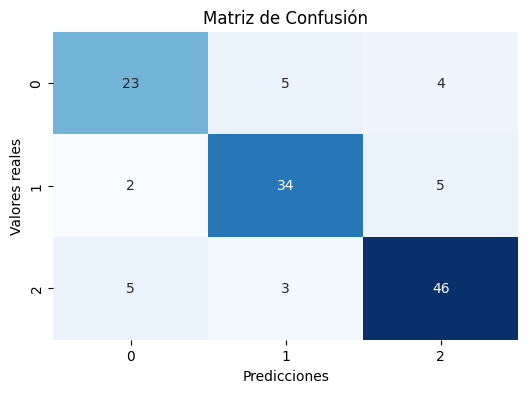

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt


# Crear el heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix_result, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión")
plt.show()


In [26]:
df_clean

,message,focus,category,answers,category_other,category_general,category_general_coded
0,literature on cardiac amyloidosis please let m...,cardiac amyloidosis,information,cardiac amyloidosis is a disorder caused by de...,information,information,0
0,literature on cardiac amyloidosis please let m...,cardiac amyloidosis,information,the term amyloidosis refers not to a single di...,information,information,0
1,migraine seems to be a spectrum of conditions ...,migraine,treatment,there is no specific cure for migraine headach...,treatment,treatment,2
1,migraine seems to be a spectrum of conditions ...,migraine,treatment,there is no absolute cure for migraine since i...,treatment,treatment,2
2,do i use pyridoxine tablets even if im pregnant,pyridoxine,contraindication,before taking pyridoxine tell your doctor and ...,information,other,1
...,...,...,...,...,...,...,...
441,if you should contact mrsa and take antibiotic...,mrsa,diagnosis,occasionally a person who has been treated for...,diagnosis,other,1
442,what if you do not have surgery to remove a pa...,intraductal papilloma,prognosis,your specialist will be able to advise you of ...,prognosis,other,1
443,thank for your information on my earlier quest...,excessive tears,treatment,your doctor may order tests to help determine ...,treatment,treatment,2
444,i have numbnesstingling in my lower right arm ...,numbnesstingling,treatment,home care your doctor should find and treat th...,treatment,treatment,2
